In [1]:
import keras
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(1337)  # 确保实验的可重复性，换句话说，保证同样的代码每次运行出来的结果是一样的

Using TensorFlow backend.


In [2]:
# 将图像复制到训练、验证和测试的目录
import os
import shutil #主要用于拷贝文件

orginal_dataset_cat_dir = 'PetImages/train_set/cat'
orginal_dataset_dog_dir = 'PetImages/train_set/dog'

base_dir = 'PetImages/cats_and_dogs'
if os.path.exists(base_dir) == False:
    os.mkdir(base_dir)#保存新数据集的目录

train_dir = os.path.join(base_dir, 'train')
if os.path.exists(train_dir) == False:
    os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
if os.path.exists(validation_dir) == False:
    os.mkdir(validation_dir)

#猫、狗的训练图像目录
train_cats_dir = os.path.join(train_dir, 'cats')
if os.path.exists(train_cats_dir) == False:
    os.mkdir(train_cats_dir)
train_dogs_dir = os.path.join(train_dir, 'dogs')
if os.path.exists(train_dogs_dir) == False:
    os.mkdir(train_dogs_dir)

#猫、狗的验证图像目录
validation_cats_dir = os.path.join(validation_dir, 'cats')
if os.path.exists(validation_cats_dir) == False:
    os.mkdir(validation_cats_dir)
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
if os.path.exists(validation_dogs_dir) == False:
    os.mkdir(validation_dogs_dir)

    
#将前2000张猫的图像复制到train_cats_dir
if len(os.listdir(train_cats_dir)) == 0:
    fnames = ['cat({}).jpg'.format(i+1) for i in range(2000)]
    for fname in fnames:
        src = os.path.join(orginal_dataset_cat_dir, fname)
        dst = os.path.join(train_cats_dir, fname)
        shutil.copyfile(src, dst)

#将接下来500张猫的图像复制到validation_cats_dir
if len(os.listdir(validation_cats_dir)) == 0:
    fnames = ['cat({}).jpg'.format(i+1) for i in range(2000,2500)]
    for fname in fnames:
        src = os.path.join(orginal_dataset_cat_dir, fname)
        dst = os.path.join(validation_cats_dir, fname)
        shutil.copyfile(src,dst)

#将前2000张狗的图像复制到train_dogs_dir
if len(os.listdir(train_dogs_dir)) == 0:
    fnames = ['dog({}).jpg'.format(i+1) for i in range(2000)]
    for fname in fnames:
        src = os.path.join(orginal_dataset_dog_dir, fname)
        dst = os.path.join(train_dogs_dir, fname)
        shutil.copyfile(src, dst)

#将接下来500张狗的图像复制到validation_dogs_dir
if len(os.listdir(validation_dogs_dir)) == 0:
    fnames = ['dog({}).jpg'.format(i+1) for i in range(2000,2500)]
    for fname in fnames:
        src = os.path.join(orginal_dataset_dog_dir, fname)
        dst = os.path.join(validation_dogs_dir, fname)
        shutil.copyfile(src,dst)


因为数据样本较少，容易过拟合，因此我们使用数据增强来减少过拟合。
数据增强(Data Aurgmenting)是从现有的训练样本中生成更多的训练数据，其方法是利用多种能够生成可信图像的随机变换来增加样本。其目标是：模型在训练时不会两次查看完全相同的图像。这让模型能够观察到数据的更多内容，从而具有更好的泛化能力。
<img src="imgs/flow_from_directory.png" width=500>
<img src="imgs/flow.png" width=500>
在Keras中，model.fit_generator()基于流式的数据生成，因为不可能先把图片进行变换，保存下来再进行训练，因为一张图片可以变换成为无数张图片，所以需要一边使用原始图片来生成新图片，一边进行训练。

In [3]:
from keras.preprocessing.image import ImageDataGenerator
IMAGE_SIZE = 64
BATCH_SIZE = 50
nb_train_samples = 2000*2
nb_validation_samples = 500*2 
class Dataset(object):
    def __init__(self):
        self.train_generator = None
        self.validation_generator = None

    def load(self, img_rows=IMAGE_SIZE, img_cols=IMAGE_SIZE):
        #利用数据增强生成器训练卷积神经网络，
        #使用ImageDataGenerator从目录中读取图像，ImageDataGenerator可以快速创建Python生成器，能够将硬盘上的图像文件自动转换为预处理好的张量批量
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range = 40,
            width_shift_range = 0.2,
            height_shift_range = 0.2,
            shear_range = 0.2,
            zoom_range = 0.2,
            horizontal_flip=True,
            fill_mode = 'nearest'
        ) #用以生成一个batch的图像数据，支持实时数据提升。训练时该函数会无限生成数据，直到达到规定的epoch次数为止。

        test_datagen = ImageDataGenerator(rescale=1./255)

        train_generator = train_datagen.flow_from_directory(
            train_dir,
            target_size=(img_rows, img_cols),
            batch_size=BATCH_SIZE,
            classes=['cats','dogs'],
            class_mode='binary' #因为使用了binary_crossentropy损失，所以需要用二进制标签
        ) #以文件夹路径为参数,生成经过数据提升/归一化后的数据,在一个无限循环中无限产生batch数据

        validation_generator = test_datagen.flow_from_directory(
            validation_dir,
            target_size=(img_rows, img_cols),
            batch_size=BATCH_SIZE,
            classes=['cats','dogs'],
            class_mode='binary'
        )

        self.train_generator = train_generator
        self.validation_generator = validation_generator

In [4]:
from skimage.transform import resize

class Model():
    def __init__(self):
        self.history = None
        
        self.model = Sequential()
        self.model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
        self.model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'))
        #在训练过程中每次更新参数时按一定概率（rate）随机断开输入神经元，Dropout层用于防止过拟合

        self.model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
        self.model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'))
        self.model.add(Dropout(0.25))

        self.model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
        self.model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'))

        self.model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
        self.model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'))
        self.model.add(Dropout(0.25))

        #把多维的输入一维化，常用在从卷积层到全连接层的过渡。Flatten不影响batch的大小。
        self.model.add(Flatten())
        self.model.add(Dense(512, activation='relu'))
        self.model.add(Dropout(0.5))
        self.model.add(Dense(1, activation='sigmoid'))
        
        self.model.compile(optimizer=RMSprop(), loss='binary_crossentropy', metrics=['accuracy']) #二分类
    
    def summary(self):
        self.model.summary()
    
    def train(self, dataset):
        '''
        执行fit_generator时，train_generator数据流返回BATCH_SIZE(train_generator的batch_size的参数)张经过随机变形的样本，
        作为一个batch训练模型，重复这一过程(fit_generator的steps_per_epoch参数)次，一个epoch结束。
        一个epoch所用样本BATCH_SIZE乘以steps_per_epoch。当epoch=20(fit_generator的epochs参数)时，模型训练结束。
        '''
        self.history = self.model.fit_generator(
            dataset.train_generator,  #steps_per_epoch：每执行一次steps,就去执行一次生产器train_generator
            steps_per_epoch = nb_train_samples // BATCH_SIZE, #一个epoch分成多少个batch(批次)
            epochs = 10,
            validation_data = dataset.validation_generator,
            validation_steps = nb_validation_samples // BATCH_SIZE  #需要从验证生成器中抽取validation_steps个批次用于评估
        )

        
    def plot_hist(self): #绘制损失曲线和精度曲线
        acc = self.history.history['acc']
        val_acc = self.history.history['val_acc']
        loss = self.history.history['loss']
        val_loss = self.history.history['val_loss']
        
        epochs = range(1,len(acc)+1)
        plt.plot(epochs,acc,'bo',label='Training_acc')
        plt.plot(epochs,val_acc,'b',label='Validation_acc')
        plt.xlabel('epochs')
        plt.ylabel('accuracy')
        plt.title('Traing and validation accuracy')
        plt.legend()
        
        plt.figure()
        
        plt.plot(epochs,loss,'bo',label='Training_loss')
        plt.plot(epochs,val_loss,'b',label='Validation_loss')
        plt.xlabel('epochs')
        plt.ylabel('loss')
        plt.title('Traing and validation loss')
        plt.legend()
        plt.show()
        
        
    def save_model(self, file_path='cat_and_dog.h5'):
        self.model.save(file_path)
#         self.model.save_weights(file_path)
    
    def predict(self, img_file):
         # 预测样本分类
        src_img = plt.imread(img_file)
        dest_img = resize(src_img, (IMAGE_SIZE, IMAGE_SIZE, 3))
        plt.imshow(dest_img)
        plt.show()
#         img = np.expand_dims(dest_img, axis=0) #预测输入要求为4维
        img = dest_img.reshape((1,) + dest_img.shape)
    
        result = self.model.predict(img)
        print(result)   # 概率
        result = self.model.predict_classes(img)
        print(result)  # 0/1
    
    def evaluate(self, dataset):
        #使用一个生成器作为数据源评估模型
        score = self.model.evaluate_generator(dataset.validation_generator, steps=2) #steps: Total number of steps (batches of samples)
        print(self.model.metrics_names)
        print("样本准确率%s: %.2f%%" % (self.model.metrics_names[1], score[1] * 100))

In [5]:
dataset = Dataset()
dataset.load()

print(type(dataset.train_generator))
for data_batch,labels_batch in dataset.train_generator:
    print('data batch shape:',data_batch.shape)
    print('labels batch shape:',labels_batch.shape)
    break

Found 4000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
<class 'keras.preprocessing.image.DirectoryIterator'>
data batch shape: (50, 64, 64, 3)
labels batch shape: (50,)


In [6]:
model = Model()
model.summary()

model.train(dataset)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 64)          0         
__________

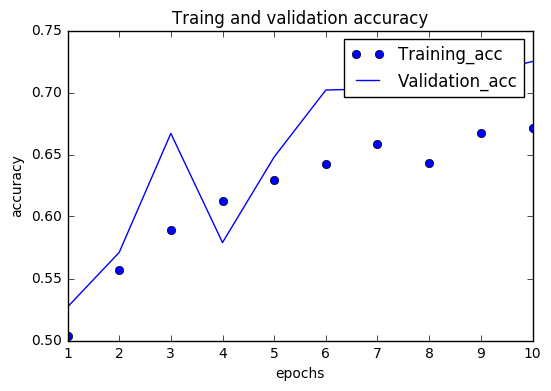

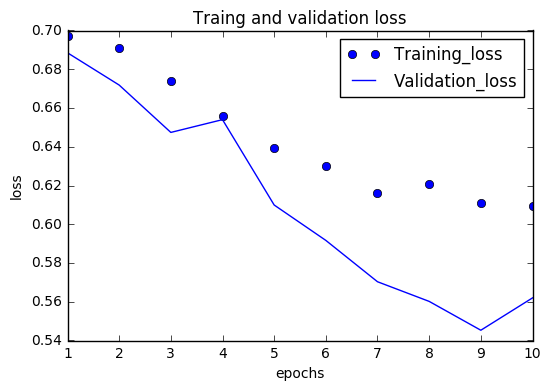

In [8]:
model.plot_hist()

In [9]:
model.evaluate(dataset)

['loss', 'acc']
样本准确率acc: 72.50%


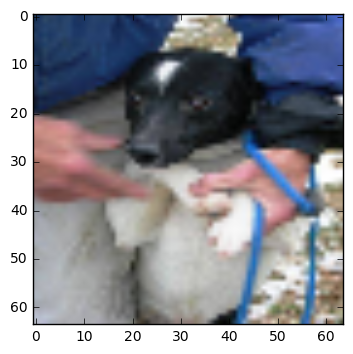

[[ 0.53771245]]
1/1 [==============================] - 0s 6ms/step
[[1]]


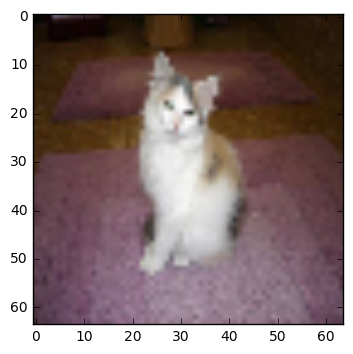

[[ 0.41532767]]
1/1 [==============================] - 0s 6ms/step
[[0]]


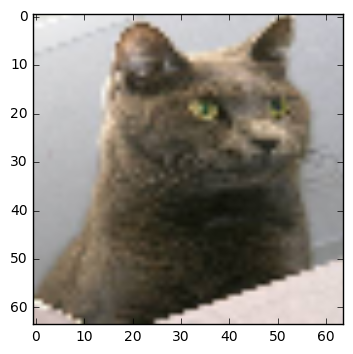

[[ 0.07525672]]
1/1 [==============================] - 0s 6ms/step
[[0]]


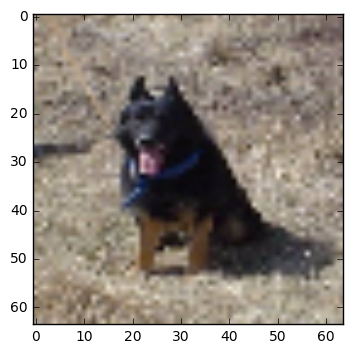

[[ 0.49739438]]
1/1 [==============================] - 0s 5ms/step
[[0]]


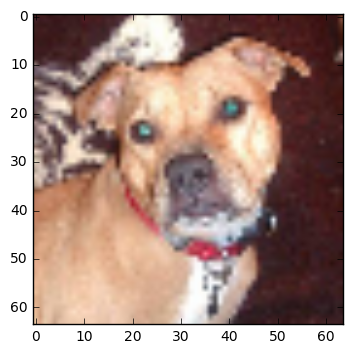

[[ 0.61410373]]
1/1 [==============================] - 0s 5ms/step
[[1]]


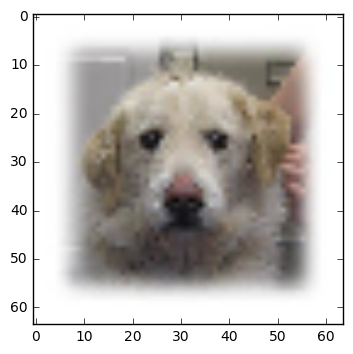

[[ 0.33505276]]
1/1 [==============================] - 0s 7ms/step
[[0]]


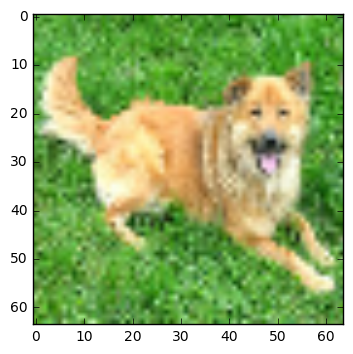

[[ 0.99816614]]
1/1 [==============================] - 0s 5ms/step
[[1]]


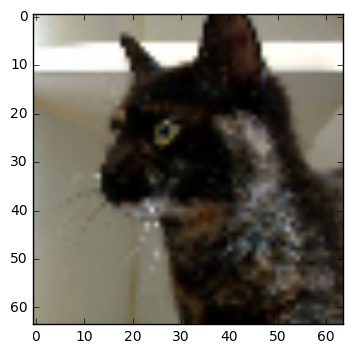

[[ 0.26741302]]
1/1 [==============================] - 0s 6ms/step
[[0]]


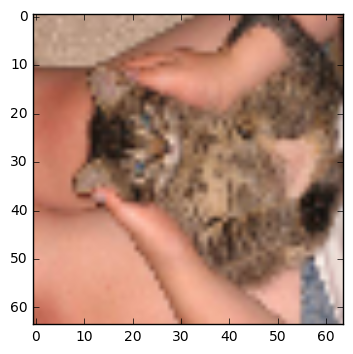

[[ 0.48344743]]
1/1 [==============================] - 0s 6ms/step
[[0]]


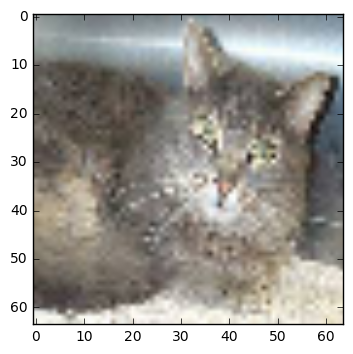

[[ 0.16303505]]
1/1 [==============================] - 0s 7ms/step
[[0]]


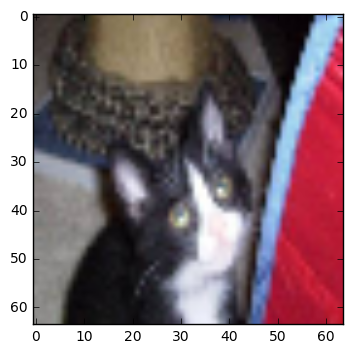

[[ 0.27825049]]
1/1 [==============================] - 0s 6ms/step
[[0]]


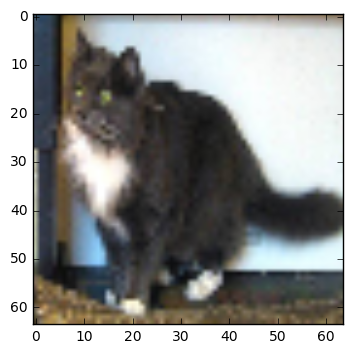

[[ 0.35373884]]
1/1 [==============================] - 0s 6ms/step
[[0]]


In [12]:
test_folder = 'PetImages/images/test'
for fname in os.listdir(test_folder):
    img = os.path.join(test_folder, fname)
    model.predict(img) #0=猫，1=狗

只靠从头开始训练自己的模型，再想提高精度十分困难，因为可用的数据太少。想要在这个问题上进一步提高精度，需要使用预训练的模型（迁移学习）！